In [ ]:
!pip install -U matplotlib keras_gpu_metrics tensorflow_datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from keras_gpu_metrics import PowerMonitorCallback

In [2]:
(dataset,), ds_info = tfds.load(
    'bee_dataset/bee_dataset_300',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`.  Stacks label fields into a multi-hot vector."""
    return (
        tf.cast(image, tf.float32) / 255.,
        tf.stack([label['cooling_output'], label['pollen_output'], label['varroa_output'], label['wasps_output']])
    )

dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).cache()
mnist_train = dataset.shuffle(ds_info.splits['train'].num_examples)
dataset = dataset.batch(128)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

Label: [0. 0. 1. 0.]


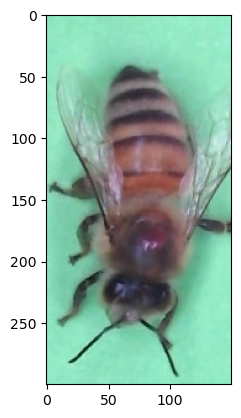

In [3]:
# Visualizes a single instance from the dataset
for input, label in dataset:
    break

example_index = 1

print(f'Label: {label[example_index].numpy()}')
plt.imshow(input[example_index]);

In [4]:
# Defines a simple convolutional network.
n_outputs = len(ds_info.features['output'])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', input_shape=(300, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='gelu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_outputs, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 74, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 72, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 17, 64)       0

In [5]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,
)

In [6]:
power_callback = PowerMonitorCallback()

history = model.fit(
    dataset,
    epochs=5,
    validation_data=dataset,
    callbacks=[power_callback],
)

Epoch 1/5
 6/59 [==>...........................] - ETA: 6s - loss: 0.5704 - binary_accuracy: 0.7725WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0460s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


59/59 [==============================] - 13s 177ms/step - loss: 0.4337 - binary_accuracy: 0.8457 - val_loss: 0.4040 - val_binary_accuracy: 0.8534
Epoch 2/5
59/59 [==============================] - 10s 169ms/step - loss: 0.3501 - binary_accuracy: 0.8626 - val_loss: 0.2419 - val_binary_accuracy: 0.8901
Epoch 3/5
59/59 [==============================] - 10s 170ms/step - loss: 0.1884 - binary_accuracy: 0.9193 - val_loss: 0.1656 - val_binary_accuracy: 0.9290
Epoch 4/5
59/59 [==============================] - 10s 171ms/step - loss: 0.1397 - binary_accuracy: 0.9419 - val_loss: 0.1147 - val_binary_accuracy: 0.9488
Epoch 5/5
59/59 [==============================] - 10s 172ms/step - loss: 0.1059 - binary_accuracy: 0.9580 - val_loss: 0.0846 - val_binary_accuracy: 0.9672


In [7]:
train_energy = power_callback.train_power_usage.estimated_energy_use()
test_energy = power_callback.test_power_usage.estimated_energy_use()
total_energy = train_energy + test_energy

print(f'Used {total_energy:.2f} Wh to train ({train_energy:.2f} Wh training / {test_energy:.2f} Wh testing)' )

Used 4.28 Wh to train (3.12 Wh training / 1.16 Wh testing)


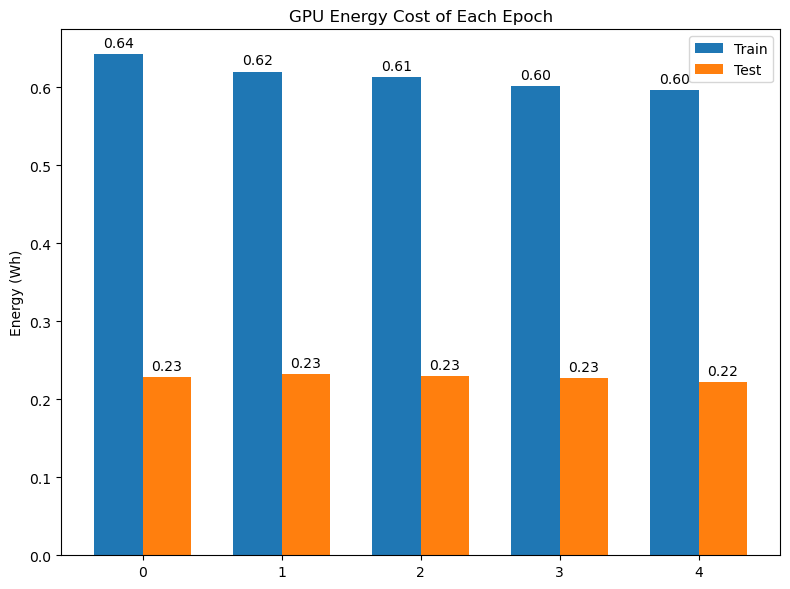

In [8]:
# View energy used per epoch

train_epochs = power_callback.train_power_usage.split_into_epochs()
test_epochs = power_callback.test_power_usage.split_into_epochs()
epochs = len(train_epochs)

x = np.arange(epochs)
train_energy = [p.estimated_energy_use() for p in train_epochs]
test_energy = [p.estimated_energy_use() for p in test_epochs]

width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, train_energy, width, label='Train')
rects2 = ax.bar(x + width/2, test_energy, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energy (Wh)')
ax.set_title('GPU Energy Cost of Each Epoch')
ax.set_xticks(x)
ax.legend()

ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)

fig.tight_layout()

plt.show();